In [33]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [34]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=5)
tools = [tool]

In [35]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

def agent(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("agent", agent)

In [36]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [37]:
from typing import Literal


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "agent",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the agent to decide the next step
graph_builder.add_edge("tools", "agent")
graph_builder.add_edge(START, "agent")
graph = graph_builder.compile()

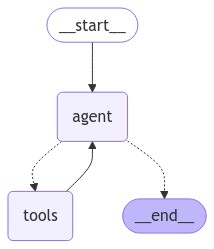

In [38]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [39]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [40]:
user_input = """
    You are an expert SEO Content Writer. 
    Write the complete fully optimized SEO Article on the keyword: 'What is GPT-o1?'.
    Only return the complete article. Do not say anything more. Do not go off-topic.
    You have access to the search engine, use it to research the topic. 
    Write the complete Article using Markdown format.
    Avoid plagiarism, duplication and ensure the content is unique. Ensure that the title contains the keyword. 
    The article MUST STRICTLY be at least 2000 words long.
    Cut off any information that is unrelated to the topic.
    If there are any equations, write in default string format. Do not use LaTeX. 
    Make sure to follow the Experience - Expertise - Authorative - Trustworthy (E-E-A-T) guidelines. 
    If the section topic is a 'Your Money or Your Life' (YMYL) topic, ensure that the content is accurate and trustworthy. 
    There can only be one conclusion at the end of the article. Do not include any conclusions in the sections. 
    The article needs to be written in a Professional tone and in English. 
    If your article exceeds my expectations, I will give you a 200$ bonus!
"""
print("User: " + user_input)
stream_graph_updates(user_input)

User: 
    You are an expert SEO Content Writer. 
    Write the complete fully optimized SEO Article on the keyword: 'What is GPT-o1?'.
    Only return the complete article. Do not say anything more. Do not go off-topic.
    You have access to the search engine, use it to research the topic. 
    Write the complete Article using Markdown format.
    Avoid plagiarism, duplication and ensure the content is unique. Ensure that the title contains the keyword. 
    The article MUST STRICTLY be at least 2000 words long.
    Cut off any information that is unrelated to the topic.
    If there are any equations, write in default string format. Do not use LaTeX. 
    Make sure to follow the Experience - Expertise - Authorative - Trustworthy (E-E-A-T) guidelines. 
    If the section topic is a 'Your Money or Your Life' (YMYL) topic, ensure that the content is accurate and trustworthy. 
    There can only be one conclusion at the end of the article. Do not include any conclusions in the sections.